# Preparing the Dataset

In [470]:
import prepare_data
import pandas as pd
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import ast
from collections import Counter
import pyphen
dic = pyphen.Pyphen(lang='en')

In [232]:
def load_df(path,list_cols):
    df = pd.read_csv(path,sep="|")
    df[list_cols] = df[list_cols].applymap(
    lambda x: ast.literal_eval(x))
    return df

In [281]:
def save_df(df,path):
    df.to_csv(path,index=False,sep="|")

In [279]:
def tokenize_pos_tagging(df):
    #Tokenize the sentences
    df[[s_sent_col,n_sent_col]] = df[[s_sent_col,n_sent_col]].applymap(lambda x: nltk.word_tokenize(x))
    
    #Filter out sentences with no english word
    #df = df.loc[df[n_sent_col].apply(lambda x: len(set(x).intersection(english_df["word"].values))) > 0]
    #df = df.loc[df[s_sent_col].apply(lambda x: len(set(x).intersection(english_df["word"].values))) > 0]
    
    #POS Tagging of sentences
    df[[s_sent_col,n_sent_col]] = df[[s_sent_col,n_sent_col]].applymap(lambda x: list(zip(*nltk.pos_tag(x))))
    
    #Divide created column into word and tag part
    df["s_sent"] = df[[s_sent_col]].apply(lambda x: x[s_sent_col][0],axis=1)
    df["s_pos"] = df[[s_sent_col]].apply(lambda x: x[s_sent_col][1],axis=1)
    df["n_sent"] = df[[n_sent_col]].apply(lambda x: x[n_sent_col][0],axis=1)
    df["n_pos"] = df[[n_sent_col]].apply(lambda x: x[n_sent_col][1],axis=1)
    
    #Drop previous columns
    df = df.drop([s_sent_col,n_sent_col],axis=1)
    
    return df

In [122]:
simple_path = "data/simple.aligned"
normal_path = "data/normal.aligned"

In [227]:
s_sent_col = "simple_sentence"
n_sent_col = "normal_sentence"

s_list_col = "s_sent"
s_pos_col = "s_pos"
n_list_col = "n_sent"
n_pos_col = "n_pos"
s_lem_col = "s_lem"
n_lem_col = "n_lem"

In [280]:
aligned_data = list(prepare_data.get_aligned_sentences(simple_path,normal_path))
df = prepare_data.create_df(aligned_data)
pos_df = tokenize_pos_tagging(df)

In [282]:
#Save Corpus to file
save_df(pos_df,"data/wikipedia_aligned_pos.csv")

# Lemmatizing

In [283]:
 def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [284]:
lemmatizer = WordNetLemmatizer()

In [285]:
df = pos_df.copy()

In [293]:
s_lemmatized = df.apply(
    lambda x: [lemmatizer.lemmatize(word,get_wordnet_pos(tag)) 
               for word,tag in zip(*[x[s_list_col],x[s_pos_col]])],axis=1)
n_lemmatized = df.apply(
    lambda x: [lemmatizer.lemmatize(word,get_wordnet_pos(tag)) 
               for word,tag in zip(*[x[n_list_col],x[n_pos_col]])],axis=1)

df[s_lem_col] = s_lemmatized
df[n_lem_col] = n_lemmatized

In [297]:
#df = df.drop([s_list_col,n_list_col],axis=1)
save_df(df[[s_lem_col,n_lem_col,s_pos_col,n_pos_col]],"data/wikipedia_aligned_lem.csv")

# Feature Implementation

In [233]:
df = load_df("data/wikipedia_aligned_lem.csv",[s_lem_col,n_lem_col,s_pos_col,n_pos_col])

In [298]:
df.head()

,simple_topic,simple_numb,normal_topic,normal_numb,s_sent,s_pos,n_sent,n_pos,s_lem,n_lem,s_sent_len,s_word_mean,n_sent_len,n_word_mean
0,"cherokee, oklahoma",0,"cherokee, oklahoma",0,"(cherokee, is, a, city, of, oklahoma, in, the,...","(NN, VBZ, DT, NN, IN, NN, IN, DT, JJ, NNS, .)","(cherokee, is, a, city, in, alfalfa, county, ,...","(NN, VBZ, DT, NN, IN, JJ, NN, ,, NN, ,, JJ, NN...","[cherokee, be, a, city, of, oklahoma, in, the,...","[cherokee, be, a, city, in, alfalfa, county, ,...",11.0,3.818182,11.0,3.818182
1,skateboard,2,skateboard,5,"(skateboard, decks, are, normally, between, 28...","(NN, NNS, VBP, RB, IN, CD, CC, CD, NNS, RB, .)","(skateboard, decks, are, usually, between, 28,...","(NN, NNS, VBP, RB, IN, CD, CC, CD, NNS, RB, .)","[skateboard, deck, be, normally, between, 28, ...","[skateboard, deck, be, usually, between, 28, a...",11.0,4.272727,11.0,4.272727
2,skateboard,2,skateboard,5,"(the, bottom, of, the, deck, can, be, printed,...","(DT, NN, IN, DT, NN, MD, VB, VBN, IN, DT, NN, ...","(the, underside, of, the, deck, can, be, print...","(DT, NN, IN, DT, NN, MD, VB, VBN, IN, DT, NN, ...","[the, bottom, of, the, deck, can, be, print, w...","[the, underside, of, the, deck, can, be, print...",21.0,3.095238,21.0,3.095238
3,skateboard,3,skateboard,6,"(the, longboard, was, made, by, two, surfers, ...","(DT, NN, VBD, VBN, IN, CD, NNS, :, CC, NN, CC,...","(this, was, created, by, two, surfers, ;, ben,...","(DT, VBD, VBN, IN, CD, NNS, :, CC, NN, CC, JJ,...","[the, longboard, be, make, by, two, surfer, ;,...","[this, be, create, by, two, surfer, ;, ben, wh...",14.0,4.000000,14.0,4.000000
4,skateboard,2,skateboard,5,"(other, materials, used, in, making, decks, fi...","(JJ, NNS, VBN, IN, VBG, NNS, NN, ,, NN, ,, NN,...","(some, of, them, have, special, materials, tha...","(DT, IN, PRP, VBP, JJ, NNS, WDT, VBP, TO, VB, ...","[other, material, use, in, make, deck, fibergl...","[some, of, them, have, special, material, that...",22.0,4.045455,22.0,4.045455


## Word and Sentence Length

In [301]:
def count_sent_word_length(df):
    len_mean_sents = df[[s_lem_col,n_lem_col]].applymap(lambda x: (len(x),np.mean([len(word) for word in x])))
    df[['s_sent_len', 's_word_mean']] = len_mean_sents[s_lem_col].apply(pd.Series)
    df[['n_sent_len', 'n_word_mean']] = len_mean_sents[n_lem_col].apply(pd.Series)
    return df

In [302]:
df = count_sent_word_length(df)

In [303]:
df.head()

,simple_topic,simple_numb,normal_topic,normal_numb,s_sent,s_pos,n_sent,n_pos,s_lem,n_lem,s_sent_len,s_word_mean,n_sent_len,n_word_mean
0,"cherokee, oklahoma",0,"cherokee, oklahoma",0,"(cherokee, is, a, city, of, oklahoma, in, the,...","(NN, VBZ, DT, NN, IN, NN, IN, DT, JJ, NNS, .)","(cherokee, is, a, city, in, alfalfa, county, ,...","(NN, VBZ, DT, NN, IN, JJ, NN, ,, NN, ,, JJ, NN...","[cherokee, be, a, city, of, oklahoma, in, the,...","[cherokee, be, a, city, in, alfalfa, county, ,...",11.0,3.818182,13.0,4.000000
1,skateboard,2,skateboard,5,"(skateboard, decks, are, normally, between, 28...","(NN, NNS, VBP, RB, IN, CD, CC, CD, NNS, RB, .)","(skateboard, decks, are, usually, between, 28,...","(NN, NNS, VBP, RB, IN, CD, CC, CD, NNS, RB, .)","[skateboard, deck, be, normally, between, 28, ...","[skateboard, deck, be, usually, between, 28, a...",11.0,4.272727,11.0,4.181818
2,skateboard,2,skateboard,5,"(the, bottom, of, the, deck, can, be, printed,...","(DT, NN, IN, DT, NN, MD, VB, VBN, IN, DT, NN, ...","(the, underside, of, the, deck, can, be, print...","(DT, NN, IN, DT, NN, MD, VB, VBN, IN, DT, NN, ...","[the, bottom, of, the, deck, can, be, print, w...","[the, underside, of, the, deck, can, be, print...",21.0,3.095238,24.0,3.791667
3,skateboard,3,skateboard,6,"(the, longboard, was, made, by, two, surfers, ...","(DT, NN, VBD, VBN, IN, CD, NNS, :, CC, NN, CC,...","(this, was, created, by, two, surfers, ;, ben,...","(DT, VBD, VBN, IN, CD, NNS, :, CC, NN, CC, JJ,...","[the, longboard, be, make, by, two, surfer, ;,...","[this, be, create, by, two, surfer, ;, ben, wh...",14.0,4.000000,13.0,3.846154
4,skateboard,2,skateboard,5,"(other, materials, used, in, making, decks, fi...","(JJ, NNS, VBN, IN, VBG, NNS, NN, ,, NN, ,, NN,...","(some, of, them, have, special, materials, tha...","(DT, IN, PRP, VBP, JJ, NNS, WDT, VBP, TO, VB, ...","[other, material, use, in, make, deck, fibergl...","[some, of, them, have, special, material, that...",22.0,4.045455,33.0,3.878788


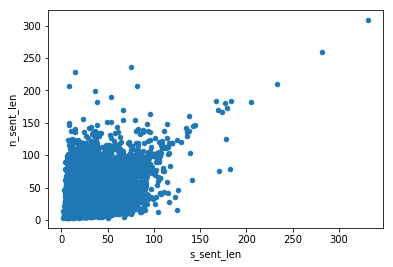

In [423]:
df.plot.scatter(x="s_sent_len",y="n_sent_len")

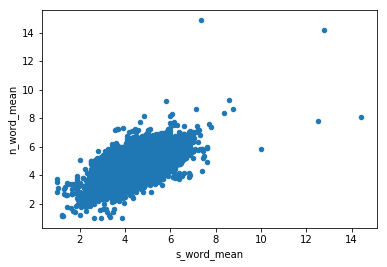

In [305]:
df.plot.scatter(x="s_word_mean",y="n_word_mean")

In [332]:
df["sent_len_ratio"] = df.apply(lambda x: x["s_sent_len"]/x["n_sent_len"],axis=1)

In [424]:
df["word_len_ratio"] = df.apply(lambda x: x["s_word_mean"]/x["n_word_mean"],axis=1)

IntervalIndex([(-0.001, 0.2], (0.2, 0.4], (0.4, 0.6], (0.6, 0.8], (0.8, 1.0], (1.0, 1.2], (1.2, 1.4], (1.4, 1.6], (1.6, 1.8]]
              closed='right',
              dtype='interval[float64]')


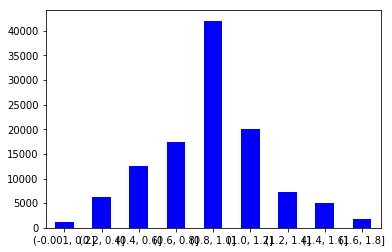

In [346]:
out = pd.cut(df["sent_len_ratio"], bins=[i/10 for i in range(0,20,2)], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
#ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
print(out.cat.categories)

IntervalIndex([(0.699, 0.75], (0.75, 0.8], (0.8, 0.85], (0.85, 0.9], (0.9, 0.95] ... (1.0, 1.05], (1.05, 1.1], (1.1, 1.15], (1.15, 1.2], (1.2, 1.25]]
              closed='right',
              dtype='interval[float64]')


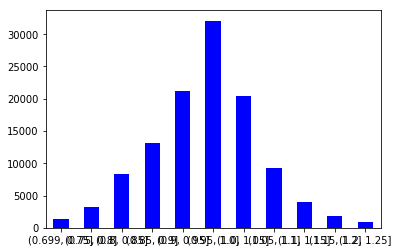

In [432]:
out = pd.cut(df["word_len_ratio"], bins=[i/100 for i in range(70,130,5)], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
#ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
print(out.cat.categories)

## Basic English

In [312]:
with open("data/basic_english.txt","r") as f:
    data = f.read()
    words = data.split(" , ")
    basic_df = pd.DataFrame(data=words,columns=["word"])
    basic_df["index"] = range(0,len(basic_df))
basic_df.head()

,word,index
0,a,0
1,able,1
2,about,2
3,account,3
4,acid,4


## Top 20k English Words

In [313]:
with open("data/20k_words.txt","r") as f:
    data = f.read()
    words = data.split("\n")
    english_df = pd.DataFrame(data=words,columns=["word"])
    english_df["index"] = range(0,len(english_df))
    non_basic_df = english_df.loc[~english_df["word"].isin(basic_df["word"])]
non_basic_df.head(10)

,word,index
7,is,7
10,by,10
13,i,13
15,it,15
18,be,18
19,are,19
23,your,23
27,more,27
28,an,28
29,was,29


## Known English Words

In [311]:
english_df = pd.concat([basic_df,non_basic_df])
english_df.head()

,word,index
0,a,0
1,able,1
2,about,2
3,account,3
4,acid,4


## Ratio between Basic and Non-Basic English Words

In [337]:
#how many words are not in the basic english
df[["s_basic_freq","n_basic_freq"]] = df[[s_lem_col,n_lem_col]].applymap(
    lambda x: len(set(x).intersection(
        basic_df["word"].values))/len(set(x)))

In [338]:
df = df.drop(["s_non_basic_freq","n_non_basic_freq"],axis=1)

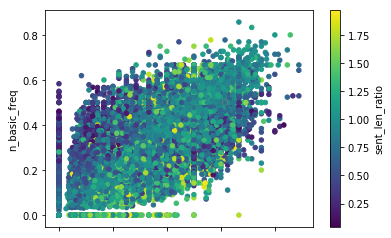

In [339]:
df.loc[df["sent_len_ratio"] < 2].plot.scatter(x="s_basic_freq",y="n_basic_freq",c="sent_len_ratio",colormap='viridis')

In [270]:
df.loc[
    (df["s_non_basic_freq"] < 0.1)
    | (df["s_non_basic_freq"] > 0.95) 
    | (df["n_non_basic_freq"] < 0.1) 
    | (df["n_non_basic_freq"] > 0.95)]

,simple_numb,normal_topic,normal_numb,s_pos,n_pos,s_lem,n_lem,s_sent_len,s_word_mean,n_sent_len,n_word_mean,s_non_basic_freq,n_non_basic_freq
24,1,chenab river,0,"(DT, NN, RB, VBZ, DT, NN, IN, NN, .)","(DT, NN, RB, VBZ, DT, NN, IN, NN, ,, NN, .)","[the, chenab, then, join, the, indus, at, mith...","[the, chenab, then, join, the, indus, at, mith...",9.0,4.111111,11.0,4.181818,0.000000,0.200000
49,14,"king's college, cambridge",16,"(DT, NN, CC, NN, NNS, IN, DT, NN, IN, DT, NN, .)","(DT, NN, CC, NN, NNS, IN, DT, NN, IN, DT, NN, ...","[a, hammer, and, sickle, survives, in, a, fram...","[a, hammer, and, sickle, survives, in, a, fram...",12.0,3.500000,18.0,3.722222,0.000000,0.166667
284,16,united states secretary of the army,27,"(RB, CD, ,, CD, :, NN, CD, ,, CD, NN, NN)","(RB, CD, ,, CD, IN, ``, MD, CD, ,, CD, NN, NN)","[november, 22, ,, 1993, -, december, 2, ,, 199...","[november, 22, ,, 1993, â, ``, may, 4, ,, 1997...",11.0,3.727273,12.0,3.166667,1.000000,0.750000
285,13,united states secretary of the army,21,"(JJ, CD, ,, CD, :, JJ, CD, ,, CD, NN, NN)","(JJ, CD, ,, CD, NN, ``, JJ, CD, ,, CD, NN, NN)","[february, 14, ,, 1977, -, january, 20, ,, 198...","[february, 14, ,, 1977, â, ``, january, 20, ,,...",11.0,3.727273,12.0,3.583333,1.000000,1.000000
286,2,united states secretary of the army,8,"(NN, JJ, NN, CD, ,, CD, :, NN, CD, ,, CD, NN, ...","(NN, JJ, NN, CD, ,, CD, NN, ``, JJ, CD, ,, CD,...","[gordon, gray, june, 20, ,, 1949, -, april, 12...","[gordon, gray, april, 28, ,, 1949, â, ``, apri...",14.0,3.357143,15.0,3.333333,1.000000,1.000000
287,17,united states secretary of the army,28,"(NN, NN, NN, VBD, CD, ,, CD, :, NN, CD, ,, CD,...","(NN, NN, NN, NNP, VBG, NNP, NN, CD, ,, CD, NN,...","[robert, m., walker, december, 2, ,, 1997, -, ...","[robert, m., walker, -lrb-, act, -rrb-, decemb...",14.0,3.571429,18.0,3.611111,1.000000,0.857143
289,9,united states secretary of the army,16,"(NN, NN, NN, NN, CD, ,, CD, :, NN, CD, ,, CD, ...","(NN, NN, NN, NN, CD, ,, CD, NN, ``, JJ, CD, ,,...","[stanley, r., resor, july, 2, ,, 1965, -, june...","[stanley, r., resor, july, 2, ,, 1965, â, ``, ...",18.0,3.555556,19.0,3.473684,1.000000,1.000000
290,7,united states secretary of the army,14,"(NN, NNS, NN, RB, CD, ,, CD, :, JJ, CD, ,, CD,...","(NN, NNS, NN, RB, CD, ,, CD, NN, ``, JJ, CD, ,...","[cyrus, robert, vance, july, 5, ,, 1962, -, ja...","[cyrus, robert, vance, july, 5, ,, 1962, â, ``...",19.0,3.684211,20.0,3.600000,1.000000,1.000000
292,5,united states secretary of the army,12,"(JJ, NN, NN, NN, CD, ,, CD, :, JJ, CD, ,, CD, ...","(JJ, NN, NN, NN, CD, ,, CD, NN, ``, JJ, CD, ,,...","[wilber, marion, brucker, july, 21, ,, 1955, -...","[wilber, marion, brucker, july, 21, ,, 1955, â...",15.0,4.200000,16.0,4.062500,1.000000,1.000000
293,1,united states secretary of the army,7,"(NNS, VBP, JJ, NN, CD, ,, CD, :, NN, CD, ,, CD...","(NNS, VBP, JJ, NN, CD, ,, CD, NN, ``, JJ, CD, ...","[kenneth, claiborne, royall, september, 18, ,,...","[kenneth, claiborne, royall, september, 18, ,,...",15.0,4.266667,16.0,4.125000,1.000000,1.000000


In [348]:
df.to_csv("data/wikipedia_aligned_lem_V2.csv",sep="|",index=False)

## Word Frequency Difference in Data

In [407]:
def get_counter(df_col):
    concat_sents = np.concatenate(df_col.tolist())
    counter = Counter(concat_sents)
    for index, row in basic_df.iterrows():
        counter.pop(row["word"],0)
    return counter

In [381]:
n_words_difference = set(np.concatenate(df[n_lem_col].tolist())).difference(set(np.concatenate(df[s_lem_col].tolist())))

In [387]:
non_basic_df.loc[non_basic_df["word"].isin(n_words_difference)]

,word,index
481,provided,481
677,stories,677
849,videos,849
890,received,890
1119,skills,1119
1143,opportunities,1143
1215,located,1215
1271,maps,1271
1351,tx,1351
1570,released,1570


In [408]:
s_counter = get_counter(df[s_lem_col])
n_counter = get_counter(df[n_lem_col])

In [411]:
s_counter.most_common(40)

[('.', 141193),
 (',', 128573),
 ('be', 116991),
 ('-rrb-', 29565),
 ('-lrb-', 29444),
 ('it', 25018),
 ('by', 15551),
 ('``', 13807),
 ("''", 12110),
 ("'s", 11406),
 ('an', 10872),
 ('his', 8446),
 ('state', 7212),
 ('also', 7067),
 ('which', 7059),
 ('use', 6561),
 ('city', 6272),
 ('bear', 6048),
 ('they', 5947),
 ('find', 5863),
 ('one', 5688),
 ('united', 4957),
 ('commune', 4950),
 ('france', 4905),
 (':', 4902),
 ('call', 4823),
 ('football', 4712),
 ('region', 4570),
 ('player', 4403),
 ('â', 4205),
 ('know', 4081),
 ('people', 4045),
 ('department', 3901),
 ('year', 3785),
 ('their', 3762),
 ('become', 3726),
 ('can', 3718),
 ('she', 3659),
 ('two', 3525),
 ('most', 3514)]

In [412]:
n_counter.most_common(40)

[(',', 180634),
 ('.', 126116),
 ('be', 110509),
 ('-lrb-', 34967),
 ('-rrb-', 34925),
 ('by', 19977),
 ('it', 19319),
 ('``', 18063),
 ("''", 15593),
 ("'s", 15191),
 ('an', 13198),
 ('his', 10751),
 ('which', 9440),
 ('state', 7519),
 ('also', 7079),
 (';', 6392),
 ('one', 6372),
 ('use', 6316),
 ('city', 5980),
 ('france', 5757),
 ('â', 5616),
 (':', 5529),
 ('bear', 5510),
 ('know', 5494),
 ('department', 5367),
 ('commune', 5181),
 ('united', 4773),
 ('their', 4519),
 ('year', 4220),
 ('include', 4194),
 ('most', 4033),
 ('county', 4021),
 ('two', 3990),
 ('they', 3947),
 ('her', 3785),
 ('world', 3756),
 ('football', 3701),
 ('become', 3682),
 ('region', 3609),
 ('american', 3594)]

## POS Tags

In [ ]:
#number of nouns
def get_numb_of_nouns(df):
    df[["s_pos_nouns","n_pos_nouns"]] = df[[s_pos_col,n_pos_col]].applymap(lambda x: [tag[0] for tag in x].count("N"))
#number of conjunctions
#number of pronouns

In [422]:
df[[s_pos_col,n_pos_col]].applymap(lambda x: [tag[0] for tag in x].count("V")).mean()

s_pos    3.027707
n_pos    3.247867
dtype: float64

In [477]:
origin_df = load_df("data/wikipedia_aligned_pos.csv",[])

In [417]:
origin_df.iloc[26]

simple_topic                                            chenab river
simple_numb                                                        0
simple_sentence    the chenab river -lrb- punjabi : à à à 3\/4 à ...
normal_topic                                            chenab river
normal_numb                                                        0
normal_sentence    the chenab river -lrb- , , , , , literally : `...
Name: 26, dtype: object

## Syllabus

In [482]:
origin_df[["s_syllabus","n_syllabus"]] = origin_df[[s_list_col,n_list_col]].applymap(lambda x: len(np.concatenate([dic.inserted(word).split("-") for word in x]))/len(x))

In [483]:
origin_df

,simple_topic,simple_numb,normal_topic,normal_numb,s_sent,s_pos,n_sent,n_pos,s_syllabus,n_syllabus
0,"cherokee, oklahoma",0,"cherokee, oklahoma",0,"('cherokee', 'is', 'a', 'city', 'of', 'oklahom...","('NN', 'VBZ', 'DT', 'NN', 'IN', 'NN', 'IN', 'D...","('cherokee', 'is', 'a', 'city', 'in', 'alfalfa...","('NN', 'VBZ', 'DT', 'NN', 'IN', 'JJ', 'NN', ',...",1.000000,1.000000
1,skateboard,2,skateboard,5,"('skateboard', 'decks', 'are', 'normally', 'be...","('NN', 'NNS', 'VBP', 'RB', 'IN', 'CD', 'CC', '...","('skateboard', 'decks', 'are', 'usually', 'bet...","('NN', 'NNS', 'VBP', 'RB', 'IN', 'CD', 'CC', '...",1.000000,1.000000
2,skateboard,2,skateboard,5,"('the', 'bottom', 'of', 'the', 'deck', 'can', ...","('DT', 'NN', 'IN', 'DT', 'NN', 'MD', 'VB', 'VB...","('the', 'underside', 'of', 'the', 'deck', 'can...","('DT', 'NN', 'IN', 'DT', 'NN', 'MD', 'VB', 'VB...",1.000000,1.000000
3,skateboard,3,skateboard,6,"('the', 'longboard', 'was', 'made', 'by', 'two...","('DT', 'NN', 'VBD', 'VBN', 'IN', 'CD', 'NNS', ...","('this', 'was', 'created', 'by', 'two', 'surfe...","('DT', 'VBD', 'VBN', 'IN', 'CD', 'NNS', ':', '...",1.000000,1.000000
4,skateboard,2,skateboard,5,"('other', 'materials', 'used', 'in', 'making',...","('JJ', 'NNS', 'VBN', 'IN', 'VBG', 'NNS', 'NN',...","('some', 'of', 'them', 'have', 'special', 'mat...","('DT', 'IN', 'PRP', 'VBP', 'JJ', 'NNS', 'WDT',...",1.000000,1.000000
5,skateboard,3,skateboard,6,"('``', 'old', 'school', ""''"", 'boards', '-lrb-...","('``', 'JJ', 'NN', ""''"", 'NNS', 'VBP', 'DT', '...","('``', 'old', 'school', ""''"", 'boards', '-lrb-...","('``', 'JJ', 'NN', ""''"", 'NNS', 'VBP', 'DT', '...",1.020408,1.015385
6,skateboard,4,skateboard,7,"('grip', 'tape', ',', 'when', 'put', 'on', 'to...","('NN', 'NN', ',', 'WRB', 'VBN', 'IN', 'TO', 'D...","('grip', 'tape', ',', 'when', 'applied', 'to',...","('NN', 'NN', ',', 'WRB', 'VBN', 'TO', 'DT', 'J...",1.000000,1.000000
7,skateboard,2,skateboard,5,"('modern', 'decks', 'are', 'different', 'in', ...","('JJ', 'NNS', 'VBP', 'JJ', 'IN', 'NN', '.', 'R...","('modern', 'decks', 'vary', 'in', 'size', ',',...","('JJ', 'NNS', 'VBP', 'IN', 'NN', ',', 'CC', 'J...",1.000000,1.000000
8,skateboard,3,skateboard,6,"('different', 'kinds', 'of', 'the', '1970s', '...","('JJ', 'NNS', 'IN', 'DT', 'NNS', 'RB', 'VBP', ...","('variants', 'of', 'the', '1970s', 'often', 'h...","('NNS', 'IN', 'DT', 'NNS', 'RB', 'VBP', 'JJ', ...",1.000000,1.000000
9,skateboard,1,skateboard,4,"('the', 'normal', 'parts', 'to', 'made', 'a', ...","('DT', 'JJ', 'NNS', 'TO', 'VB', 'DT', 'JJ', 'N...","('the', 'usual', 'parts', 'to', 'design', 'a',...","('DT', 'JJ', 'NNS', 'TO', 'VB', 'DT', 'JJ', 'N...",1.000000,1.000000


In [478]:
origin_df.head()

,simple_topic,simple_numb,normal_topic,normal_numb,s_sent,s_pos,n_sent,n_pos
0,"cherokee, oklahoma",0,"cherokee, oklahoma",0,"('cherokee', 'is', 'a', 'city', 'of', 'oklahom...","('NN', 'VBZ', 'DT', 'NN', 'IN', 'NN', 'IN', 'D...","('cherokee', 'is', 'a', 'city', 'in', 'alfalfa...","('NN', 'VBZ', 'DT', 'NN', 'IN', 'JJ', 'NN', ',..."
1,skateboard,2,skateboard,5,"('skateboard', 'decks', 'are', 'normally', 'be...","('NN', 'NNS', 'VBP', 'RB', 'IN', 'CD', 'CC', '...","('skateboard', 'decks', 'are', 'usually', 'bet...","('NN', 'NNS', 'VBP', 'RB', 'IN', 'CD', 'CC', '..."
2,skateboard,2,skateboard,5,"('the', 'bottom', 'of', 'the', 'deck', 'can', ...","('DT', 'NN', 'IN', 'DT', 'NN', 'MD', 'VB', 'VB...","('the', 'underside', 'of', 'the', 'deck', 'can...","('DT', 'NN', 'IN', 'DT', 'NN', 'MD', 'VB', 'VB..."
3,skateboard,3,skateboard,6,"('the', 'longboard', 'was', 'made', 'by', 'two...","('DT', 'NN', 'VBD', 'VBN', 'IN', 'CD', 'NNS', ...","('this', 'was', 'created', 'by', 'two', 'surfe...","('DT', 'VBD', 'VBN', 'IN', 'CD', 'NNS', ':', '..."
4,skateboard,2,skateboard,5,"('other', 'materials', 'used', 'in', 'making',...","('JJ', 'NNS', 'VBN', 'IN', 'VBG', 'NNS', 'NN',...","('some', 'of', 'them', 'have', 'special', 'mat...","('DT', 'IN', 'PRP', 'VBP', 'JJ', 'NNS', 'WDT',..."


In [441]:
s_sentence = "Shakaria is a 5-month-old puppy She lives in Kenya's Maasai Mara Kenya is a country in East Africa Maasai Mara is a protected area full of animals Shakaria is usually playful She gets serious about her job, though"

In [442]:
n_sentence = "Five-month-old bloodhound Shakaria gambols through the long savannah grasses of Kenya's Maasai Mara reserve her playful mood swiftly turning to keen determination as she is ordered to track a human scent."


In [437]:
np.mean([len(word) for word in s_sentence])

4.944444444444445

In [439]:
np.mean([len(word) for word in n_sentence])

5.580645161290323

In [449]:
n_tok = nltk.word_tokenize(n_sentence)
s_tok = nltk.word_tokenize(s_sentence)

In [453]:
sum([1 for word in n_tok if word not in basic_df["word"].values])/len(n_tok)

0.7575757575757576

In [454]:
sum([1 for word in s_tok if word not in basic_df["word"].values])/len(s_tok)

0.725

In [458]:

dic.inserted('Rohit').split("-")

['Ro', 'hit']

In [463]:
n_syb = [dic.inserted(word).split("-") for word in n_tok]
s_syb = [dic.inserted(word).split("-") for word in s_tok]

In [466]:
len(np.concatenate(n_syb))/len(n_tok)

1.606060606060606

In [467]:
len(np.concatenate(s_syb))/len(s_tok)

1.425

In [469]:
len(s_tok)/6

6.666666666666667